In [38]:
from __future__ import division
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize
from collections import defaultdict
import pandas as pd
import cv2
import os
import time
import shapely
import shapely.wkt
from shapely.geometry import MultiPolygon, Polygon

import warnings
warnings.filterwarnings("ignore")

In [3]:
def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands).astype(np.float32)
    for i in range(3):
        a = 0 
        b = 1 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.float32)

def CCCI_index(m, rgb):
    RE  = resize(m[5,:,:], (rgb.shape[0], rgb.shape[1])) 
    MIR = resize(m[7,:,:], (rgb.shape[0], rgb.shape[1])) 
    R = rgb[:,:,0]
    # canopy chloropyll content index
    CCCI = (MIR-RE)/(MIR+RE)*(MIR-R)/(MIR+R)
    return CCCI    

In [4]:
data = pd.read_csv('../input/train_wkt_v4.csv')
data = data[data.MultipolygonWKT != 'MULTIPOLYGON EMPTY']
grid_sizes_fname = '../input/grid_sizes.csv'
wkt_fname = '../input/train_wkt_v4.csv'
image_fname = '../input/three_band/'

In [5]:
len(data), len(data[data.ClassType == 7])

(138, 2)

In [6]:
len(data[data.ClassType == 7].ImageId)

2

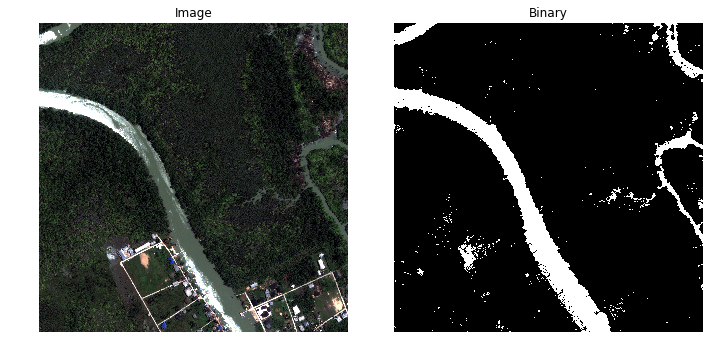

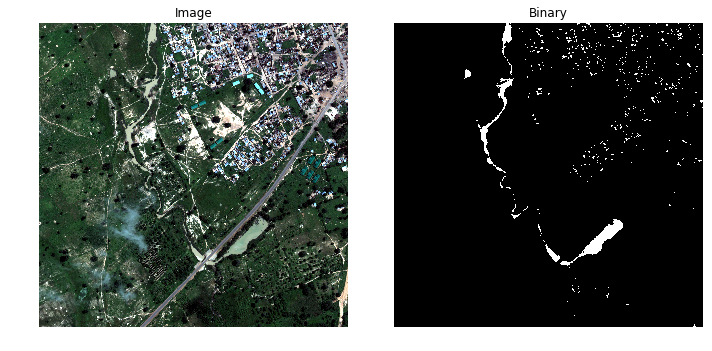

In [7]:
for IM_ID in data[data.ClassType == 7].ImageId:
    # read rgb and m bands
    rgb = tiff.imread('../input/three_band/{}.tif'.format(IM_ID))
    rgb = np.rollaxis(rgb, 0, 3)
    m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
    
    # get our index
    CCCI = CCCI_index(m, rgb) 
    
    # you can look on histogram and pick your favorite threshold value(0.11 is my best)
    binary = (CCCI > 0.11).astype(np.float32)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(stretch_8bit(rgb))
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(binary, cmap='binary_r')
    ax[1].set_title('Binary')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

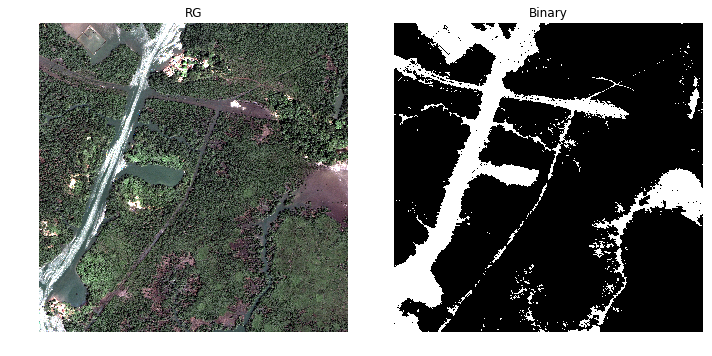

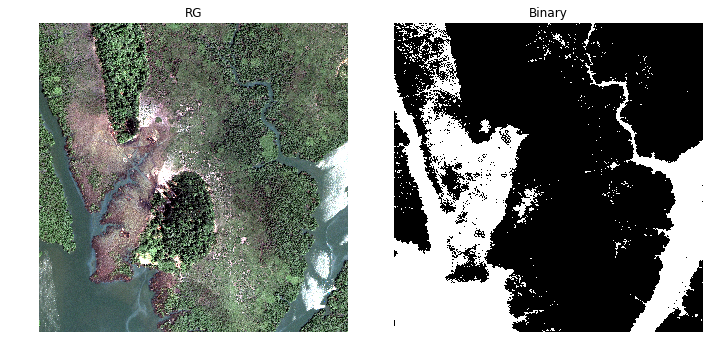

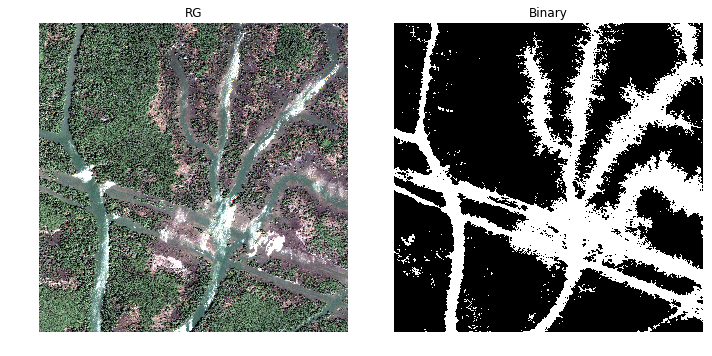

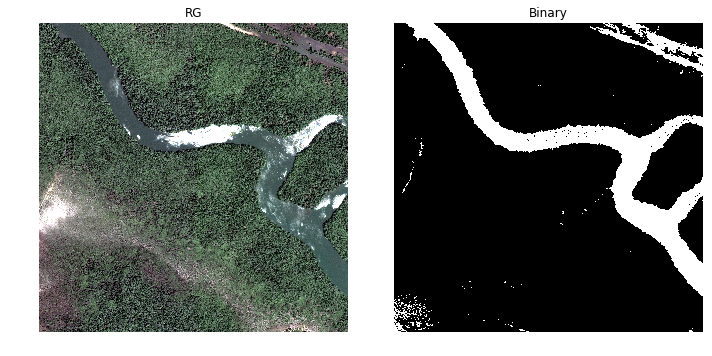

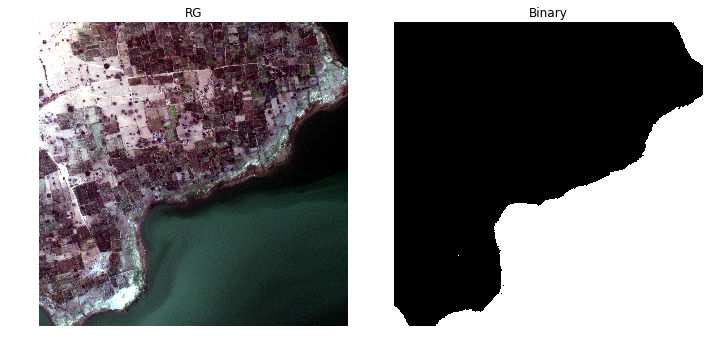

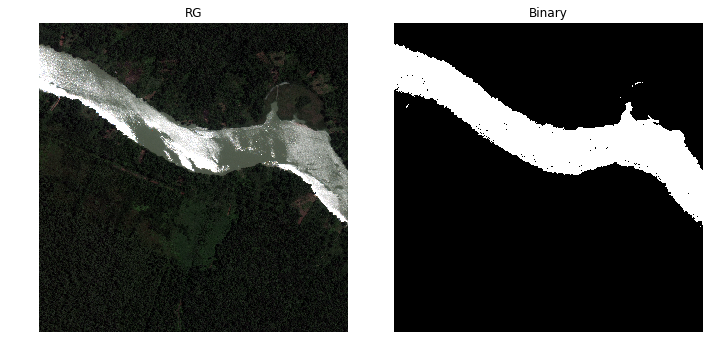

In [8]:
# take some pictures from test 
waterway_test = ['6080_4_3','6080_4_0',
                 '6080_1_3', '6080_1_1',
                 '6150_3_4', '6050_2_1']

for IM_ID in waterway_test:
    # read rgb and m bands
    rgb = tiff.imread('../input/three_band/{}.tif'.format(IM_ID))
    rgb = np.rollaxis(rgb, 0, 3)
    m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
    
    # get our index
    CCCI = CCCI_index(m, rgb) 
    
    # you can look on histogram and pick your favorite threshold value(0.11 is my best)
    binary = (CCCI > 0.11).astype(np.float32)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
    ax = axes.ravel()
    ax[0].imshow(stretch_8bit(rgb))
    ax[0].set_title('RG')
    ax[0].axis('off')
    ax[1].imshow(binary, cmap='binary_r')
    ax[1].set_title('Binary')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

In [31]:
inDir = '../input'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
binary_threshold = 500*1000

In [32]:
# creating polygons from bit masks
def mask_to_polygons(mask, epsilon=0.8, min_area=1.):
    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min



In [81]:
start = time.time()

print("predict waterway")
df = pd.read_csv('../output/subm/final_3.csv')
print(df.head())

for idx, row in df.iterrows():
    if idx % 500 == 0: print(idx)

    id, IM_ID = row[0], row[0]
    kls = row[1] - 1
    if kls != 7:
        continue

    rgb = tiff.imread('../input/three_band/{}.tif'.format(IM_ID))
    rgb = np.rollaxis(rgb, 0, 3)
    m = tiff.imread('../input/sixteen_band/{}_M.tif'.format(IM_ID))
    
    # get our index
    CCCI = CCCI_index(m, rgb) 
    
    # you can look on histogram and pick your favorite threshold value(0.11 is my best)
    binary = (CCCI > 0.11).astype(np.float32)
    if np.sum(binary) < binary_threshold:
#         print(IM_ID)
        continue
        
    msk = binary
    pred_polygons = mask_to_polygons(msk)
    x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
    y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

    x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

    scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                  origin=(0, 0, 0))

    df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
print(df.head())

print('running time: %d second' %(time.time() - start))

predict waterway
    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0089743035872592 -0.00339540...
1  6120_2_4          2  MULTIPOLYGON (((0.0090609072406947 -0.00092995...
2  6120_2_4          3  MULTIPOLYGON (((0.0091475108941303 -0.00134085...
3  6120_2_4          4  MULTIPOLYGON (((0.0090933836107331 -0.00578515...
4  6120_2_4          5  MULTIPOLYGON (((0.0091691618074892 -0.00879127...
0
500
1000
1500
2000
2500
3000
3500
4000
    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0089743035872592 -0.00339540...
1  6120_2_4          2  MULTIPOLYGON (((0.0090609072406947 -0.00092995...
2  6120_2_4          3  MULTIPOLYGON (((0.0091475108941303 -0.00134085...
3  6120_2_4          4  MULTIPOLYGON (((0.0090933836107331 -0.00578515...
4  6120_2_4          5  MULTIPOLYGON (((0.0091691618074892 -0.00879127...
running time: 707 second


In [82]:
df.ClassType = df.ClassType.astype(np.int32)
df.to_csv('../output/subm/result_1.csv', index=False)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4290 entries, 0 to 4289
Data columns (total 3 columns):
ImageId            4290 non-null object
ClassType          4290 non-null int32
MultipolygonWKT    4290 non-null object
dtypes: int32(1), object(2)
memory usage: 83.9+ KB
